# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    auc, roc_curve, roc_auc_score, average_precision_score
)
from sklearn.metrics import confusion_matrix
from pandas.io.formats import style
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [5]:
## parsing data here
images, labels = parse_data(df)

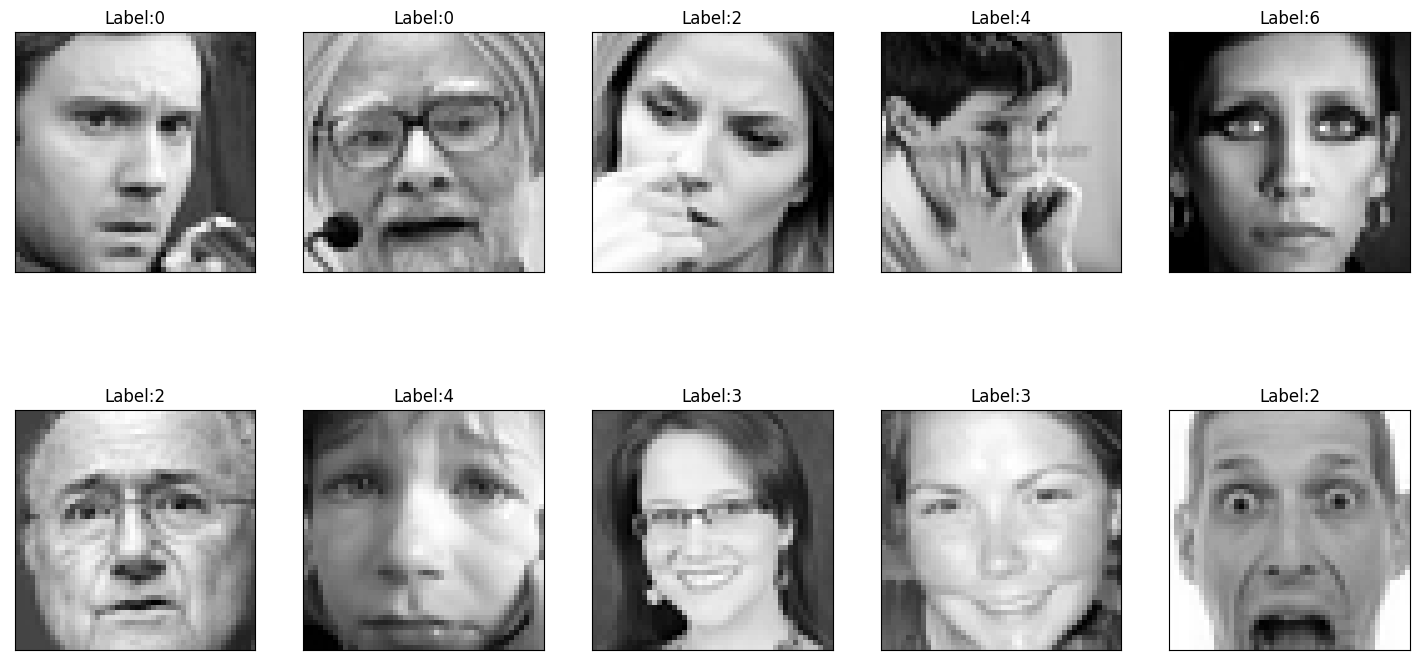

In [6]:
## showing images here
show_img(images, labels)

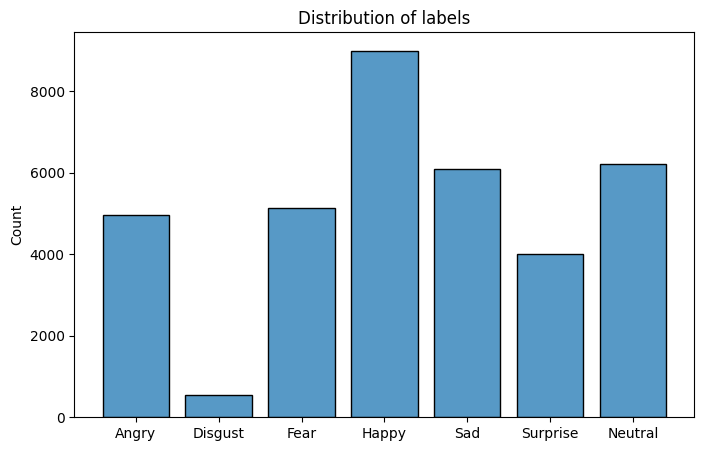

In [7]:
labels_name = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# show distribution of labels
plt.figure(figsize=(8, 5))
sns.histplot(labels, discrete=True, shrink=.8)
plt.title('Distribution of labels')
plt.xticks(ticks=range(len(labels_name)), labels=labels_name)
plt.show()

=> Imbalanced dataset

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [8]:
# flatten images
# from a 3-dimensional array (number of samples, height, width) 
# into a 2-dimensional array (number of samples, number of pixels)
n_samples, height, width = images.shape
images_flat = images.reshape(n_samples, height * width)

In [9]:
from sklearn.decomposition import PCA

def visualize_pca_projection(images_flat, labels, n_components=2):
    #perform PCA on flattened images
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(images_flat)

    # define color for each unique labels
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']

    # scatter plot for each uique label
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(np.unique(labels)):
        plt.scatter(transformed_data[labels == label, 0], transformed_data[labels == label, 1], 
                    label=label, alpha=0.7, color=colors[i % len(colors)])

    # format plot
    plt.title('Data Projected onto Two Principal Components')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(title='Labels', loc='best')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

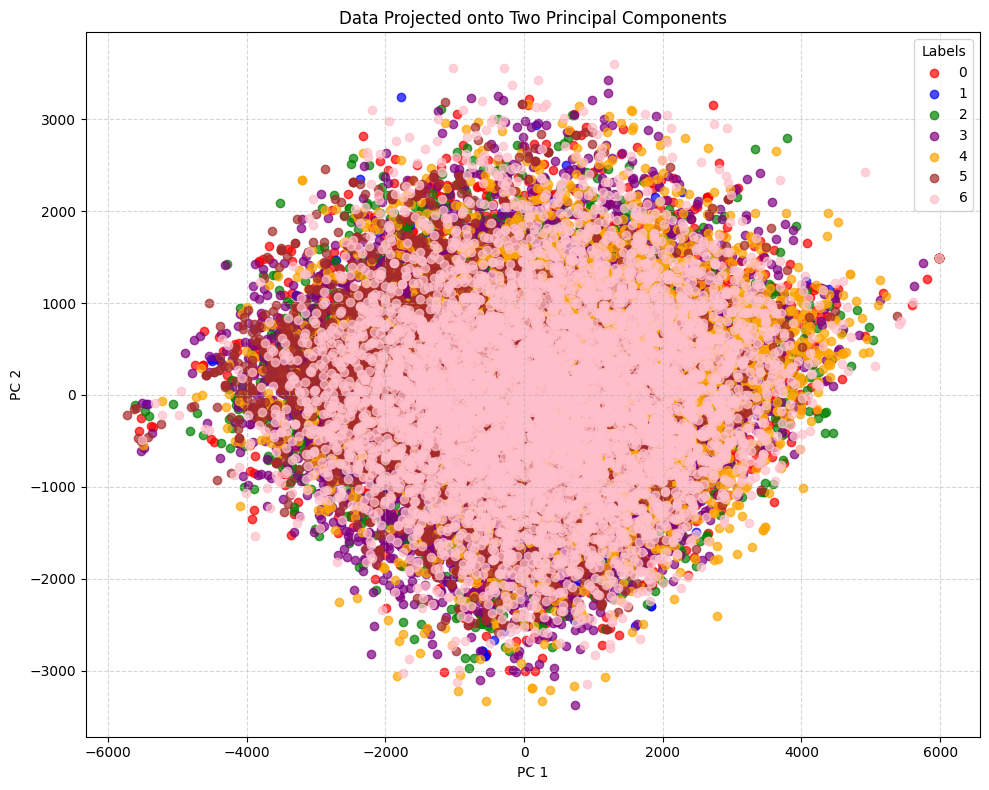

In [10]:
visualize_pca_projection(images_flat, labels)

Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

To determine the optimal number of principal components (PCs) for PCA, we use the cumulative explained variance method. The goal is to retain a sufficient amount of total variance (e.g., 90%) with the fewest number of PCs.

##### Steps
1. **Fit PCA**: Train PCA on the flattened image data.
2. **Calculate Explained Variance**: Obtain the variance explained by each PC.
3. **Cumulative Explained Variance**: Compute the cumulative sum of explained variances.
4. **Determine Optimal PCs**: Find the smallest number of PCs where cumulative explained variance meets or exceeds the threshold (e.g., 90%).
5. **Visualize**: Plot cumulative explained variance and mark the optimal number of PCs.

We will choose a threshold of 90%

Let $\lambda_i$ be the eigenvalues corresponding to each principal component, which represent the variance explained by each component. The cumulative explained variance for the first $k$ components is given by:

Cumulative Explained Variance $=\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^n \lambda_i}$
where $n$ is the total number of components. We select the smallest $k$ such that:
$$
\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^n \lambda_i} \geq 0.90
$$

Optimal number of principal components to preserve 90.0% variance: 104


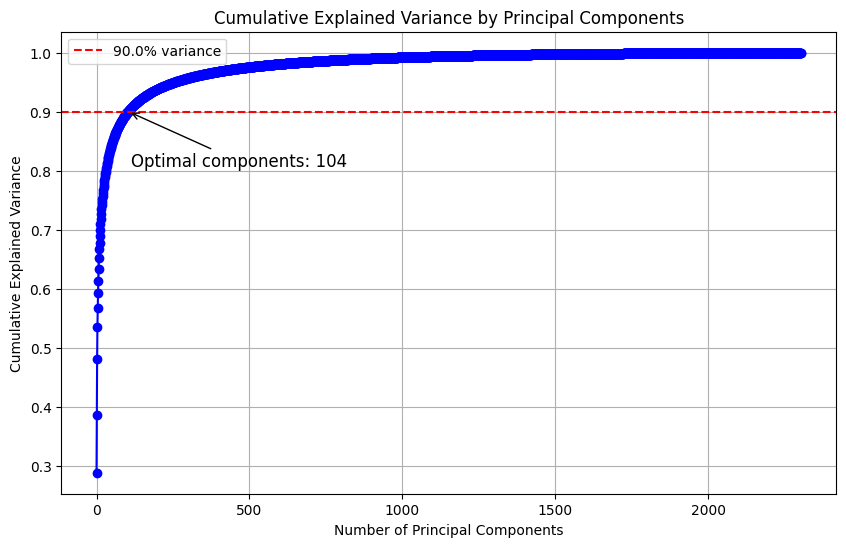

In [11]:
# perform PCA
pca = PCA()
pca.fit(images_flat)

# get the explained variance by each principal component
explained_variance = pca.explained_variance_

# compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance) / np.sum(explained_variance)

# set the variance threshold
variance_threshold = 0.90

# determine the optimal number of principal components
optimal_num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
print(f"Optimal number of principal components to preserve {variance_threshold*100}% variance:", optimal_num_components)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f'{variance_threshold*100}% variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.legend()
plt.grid(True)

# highlight the optimal number of components on the plot
plt.annotate(f'Optimal components: {optimal_num_components}', 
             xy=(optimal_num_components, cumulative_explained_variance[optimal_num_components - 1]), 
             xytext=(optimal_num_components + 10, cumulative_explained_variance[optimal_num_components - 1] - 0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12,
             horizontalalignment='left',
             verticalalignment='bottom')

plt.show()

On the plotted chart, we see what number of principal components we need.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

### 3.1. Original Data

#### 3.1.1 Using Sklearn to train 3 Machine learning models, include Logistic Regression, KNN, Random Forest

In [8]:
def format_table(df: pd.DataFrame) -> style.Styler:
    return (
        df.style
        .set_properties(
            **{
                'font-size': '10pt',
                'width': '100px',
                'height': '30px',
                'text-align': 'center'
            }
        )
        .set_table_styles([
            {
                'selector': 'th',
                'props': [
                    ('text-align', 'center'),
                    ('font-size', '10pt')
                ]
            },
            {
                'selector': 'caption',
                'props': [
                    ('caption-side', 'bottom'),
                    ('text-align', 'center'),
                    ('font-size', '12pt'),
                    ('padding-top', '10pt')
                ]
            }
        ])
        .set_table_attributes(
            'style="font-size: 16px; margin: 0 auto;"'
        )
    )

In [9]:
n_samples, height, width = images.shape
images_flat = images.reshape(n_samples, height * width)

* Split the dataset

In [10]:
def split_data(images_flat: np.ndarray, emotions: np.ndarray, test_size: float, random_state: int):
    x_ = images_flat
    y_ = emotions
    x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size=test_size, random_state=random_state)

    return x_, y_, x_train_, x_test_, y_train_, y_test_


x, y, x_train, x_test, y_train, y_test = split_data(images_flat, labels, test_size=0.2, random_state=42)

* Scaling

In [11]:
# define a function to scale 
def scaling_data(x_train: np.ndarray, x_test: np.ndarray):
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, x_test_scaled
x_train, x_test = scaling_data(x_train, x_test)


* Creating Pipelines

In [12]:
def create_pipelines() -> Dict[str, OneVsRestClassifier]:
    return {
        'K Nearest Neighbors': OneVsRestClassifier(make_pipeline(KNeighborsClassifier(n_jobs=-1))),
        'Logistic Regression': OneVsRestClassifier(make_pipeline(LogisticRegression(n_jobs=-1))),
        'Random Forest': OneVsRestClassifier(make_pipeline(RandomForestClassifier(n_jobs=-1))),
    }
pipelines = create_pipelines()

* Getting metrics from pipelines

In [13]:
def metrics_from_pipelines(x_train: pd.DataFrame,
                           y_train: pd.Series,
                           x_test: pd.DataFrame,
                           y_test: pd.Series) -> style.Styler:
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_aps = []
    train_precs = []
    train_recs = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_aps = []
    test_precs = []
    test_recs = []

    for _, pipeline in pipelines.items():
        pipeline.fit(x_train, y_train)
        y_pred_test = pipeline.predict(x_test)
        y_pred_train = pipeline.predict(x_train)

        y_probs_test = pipeline.predict_proba(x_test)
        y_probs_train = pipeline.predict_proba(x_train)

        train_roc_aucs.append(roc_auc_score(
            y_train, y_probs_train, multi_class='ovr'))
        test_roc_aucs.append(roc_auc_score(
            y_test, y_probs_test, multi_class='ovr'))

        train_aps.append(average_precision_score(y_train, y_probs_train, average='weighted'))
        test_aps.append(average_precision_score(y_test, y_probs_test, average='weighted'))

        train_accs.append(accuracy_score(y_train, y_pred_train))
        test_accs.append(accuracy_score(y_test, y_pred_test))

        train_f1s.append(f1_score(y_train, y_pred_train, average='weighted'))
        test_f1s.append(f1_score(y_test, y_pred_test, average='weighted'))

        train_precs.append(precision_score(
            y_train, y_pred_train, average='weighted'))
        test_precs.append(precision_score(
            y_test, y_pred_test, average='weighted'))

        train_recs.append(recall_score(
            y_train, y_pred_train, average='weighted'))
        test_recs.append(recall_score(y_test, y_pred_test, average='weighted'))

    # Aggregate the performance metric lists into separate dataframes
    train_metrics = pd.DataFrame({
        'model': pipelines.keys(),
        'accuracy': train_accs,
        'f1_score': train_f1s,
        'roc_auc': train_roc_aucs,
        'ap': train_aps,
        'precision': train_precs,
        'recall': train_recs
    })

    test_metrics = pd.DataFrame({
        'model': pipelines.keys(),
        'accuracy': test_accs,
        'f1_score': test_f1s,
        'roc_auc': test_roc_aucs,
        'ap': test_aps,
        'precision': test_precs,
        'recall': test_recs
    })

    # Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))

    # Sorting coulmns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'ap_train',
                                                             'ap_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test'])

    return train_test_metrics.set_index('model').transpose().style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'width': '200px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 3. Model performance metrics')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')


metrics_from_pipelines(x_train, y_train, x_test, y_test)

model,K Nearest Neighbors,Logistic Regression,Random Forest
accuracy_train,0.539587,0.470236,0.998433
accuracy_test,0.345361,0.353302,0.475759
f1_score_train,0.535302,0.459874,0.998432
f1_score_test,0.338618,0.340080,0.457374
roc_auc_train,0.903433,0.807367,0.999959
roc_auc_test,0.690873,0.671809,0.784795
ap_train,0.567057,0.481582,0.999737
ap_test,0.309173,0.322531,0.506407
precision_train,0.575164,0.464822,0.998433
precision_test,0.364813,0.337340,0.497268


* Remark all models on the table 3 in one vs rest classifier.
    - The best model is Random Forest with the highest accuracy, f1_score, roc_auc, ap, precision, and recall on the test set.
    - The worst model is K Nearest Neighbors with the lowest accuracy, f1_score, roc_auc, ap, precision, and recall on the test set.
    - The second best model is Logistic Regression with the second highest accuracy, f1_score, roc_auc, ap, precision, and recall on the test set. 


In [34]:
# due to the long training time, we save the model to conserve time
filename = 'ML_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

{'K Nearest Neighbors': OneVsRestClassifier(estimator=Pipeline(steps=[('kneighborsclassifier',
                                                KNeighborsClassifier(n_jobs=-1))])),
 'Logistic Regression': OneVsRestClassifier(estimator=Pipeline(steps=[('logisticregression',
                                                LogisticRegression(n_jobs=-1))])),
 'Random Forest': OneVsRestClassifier(estimator=Pipeline(steps=[('randomforestclassifier',
                                                RandomForestClassifier(n_jobs=-1))]))}

* Cross Validation

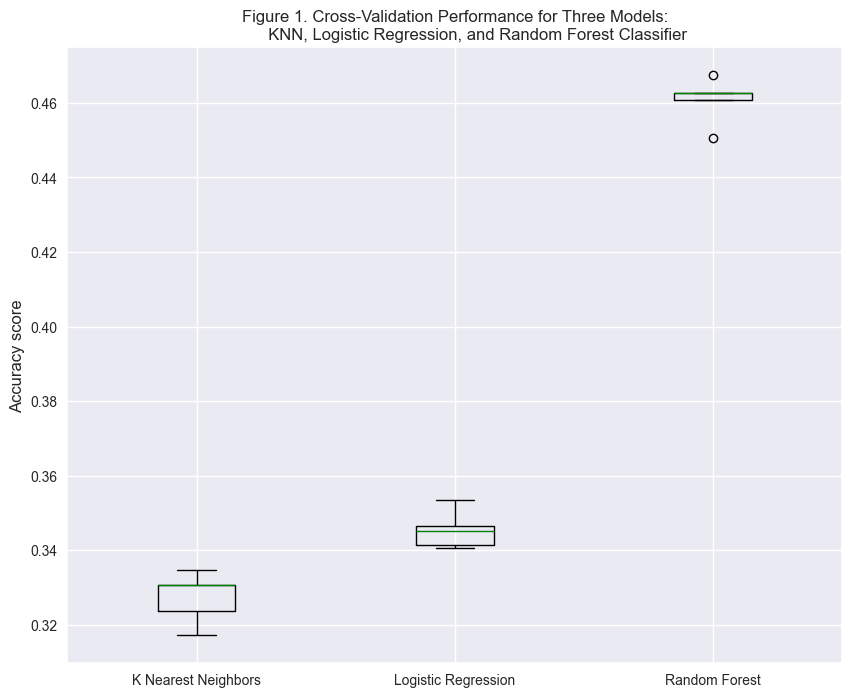

,Test Set Accuracy
K Nearest Neighbors,0.345361
Logistic Regression,0.353302
Random Forest,0.472555


In [18]:
def boxplot_cv_performances_from_pipes(x_train_: pd.DataFrame,
                                       y_train_: pd.Series,
                                       x_test_: pd.DataFrame,
                                       y_test_: pd.Series) -> pd.DataFrame:
    results = []

    for pipeline in pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train_, y_train_, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=list(pipelines.keys()),
                medianprops={'color': 'green'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.title('Figure 1. Cross-Validation Performance for Three Models:\n\
          KNN, Logistic Regression, and Random Forest Classifier')
    plt.show()

    # Test set performance
    test_set_performance = pd.DataFrame(index=list(pipelines.keys()),
                                        columns=['Test Set Accuracy'])
    for name, pipeline in pipelines.items():
        pipeline.fit(x_train_, y_train_)
        y_pred = pipeline.predict(x_test_)
        test_set_performance.loc[name, 'Test Set Accuracy'] = accuracy_score(y_test_, y_pred)

    return test_set_performance


boxplot_cv_performances_from_pipes(x_train, y_train, x_test, y_test)

* ROC, AUC plot

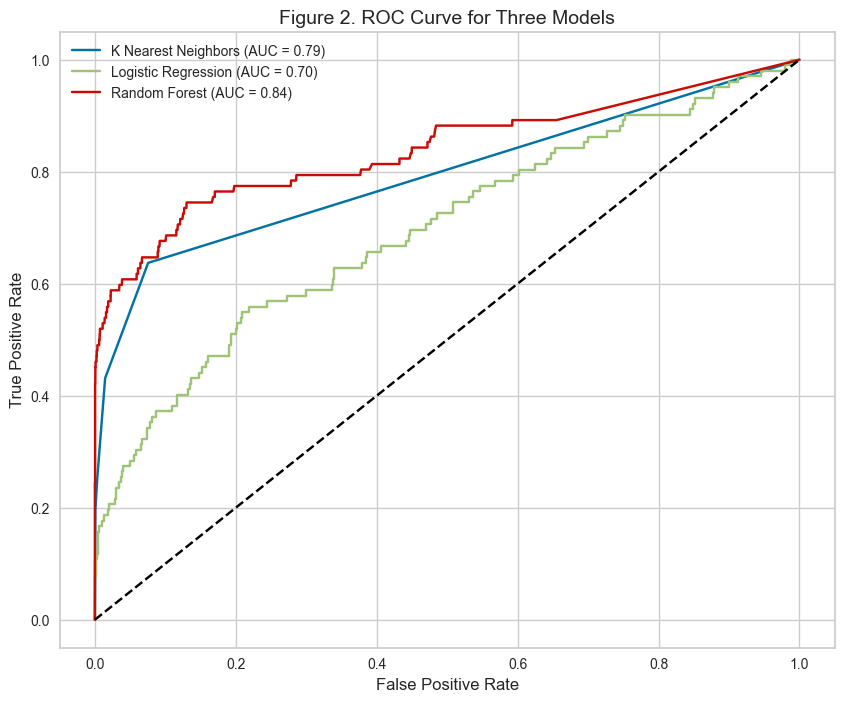

In [18]:
def plot_roc_curve(x_train_: pd.DataFrame,
                   y_train_: pd.Series,
                   x_test_: pd.DataFrame,
                   y_test_: pd.Series) -> None:
    plt.figure(figsize=(10, 8))
    [plt.plot(*roc_curve(y_test_, pipeline.predict_proba(x_test_)[:, 1], pos_label=1)[:2], 
              label=f'{name} (AUC = {auc(*roc_curve(y_test_, pipeline.predict_proba(x_test_)[:, 1], pos_label=1)[:2]):.2f})') 
     for name, pipeline in pipelines.items()]
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Figure 2. ROC Curve for Three Models', fontsize=14)
    plt.legend()
    plt.show()
plot_roc_curve(x_train, y_train, x_test, y_test)

* Hyperparameter Tuning

In [18]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(x_train_: pd.DataFrame,
                           y_train_: pd.Series) -> Dict[str, OneVsRestClassifier]:
    tuned_pipelines = {
        'K Nearest Neighbors': OneVsRestClassifier(make_pipeline(KNeighborsClassifier(n_jobs=-1))),
        'Logistic Regression': OneVsRestClassifier(make_pipeline(LogisticRegression(n_jobs=-1)))
    }

    for name, pipeline in tuned_pipelines.items():
        if name == 'K Nearest Neighbors':
            # Define the number of neighbors to test
            param_grid = {
                'estimator__kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
                'estimator__kneighborsclassifier__weights': ['uniform', 'distance']
            }
        elif name == 'Logistic Regression':
            # Define the regularization parameter space
            param_grid = {
                'estimator__logisticregression__C': [0.01, 0.1, 1, 10, 100],
                'estimator__logisticregression__penalty': ['l1', 'l2']
            }
        # Perform grid search with 5-fold cross-validation
        kf = KFold(n_splits=5)
        grid_search = GridSearchCV(pipeline, param_grid, cv=kf)
        grid_search.fit(x_train_, y_train_)

        print(f"Best parameters for {name}: {grid_search.best_params_}")

    return tuned_pipelines

tuned_KNN_and_LR_pipelines = hyperparameter_tuning(x_train, y_train)

Best parameters for K Nearest Neighbors: {'estimator__kneighborsclassifier__n_neighbors': 7, 'estimator__kneighborsclassifier__weights': 'distance'}
Best parameters for Logistic Regression: {'estimator__logisticregression__C': 0.01, 'estimator__logisticregression__penalty': 'l2'}


* Tuning for random forest

In [21]:
# tuning random forest low n_estimators
def hyperparameter_tuning_rf(x_train_: pd.DataFrame,
                             y_train_: pd.Series) -> Dict[str, OneVsRestClassifier]:
    tuned_pipelines = {
        'Random Forest': OneVsRestClassifier(make_pipeline(RandomForestClassifier(n_jobs=-1)))
    }

    for name, pipeline in tuned_pipelines.items():
        if name == 'Random Forest':
            # Define the number of trees to test
            param_grid = {
                'estimator__randomforestclassifier__n_estimators': [50, 100, 150],
                'estimator__randomforestclassifier__max_depth': [3, 5, 7]
            }
        # Perform grid search with 5-fold cross-validation
        kf = KFold(n_splits=5)
        grid_search = GridSearchCV(pipeline, param_grid, cv=kf)
        grid_search.fit(x_train_, y_train_)

        print(f"Best parameters for {name}: {grid_search.best_params_}")

    return tuned_pipelines

tuned_RF_pipelines = hyperparameter_tuning_rf(x_train, y_train)

Best parameters for Random Forest: {'estimator__randomforestclassifier__max_depth': 7, 'estimator__randomforestclassifier__n_estimators': 100}


In [22]:
# save tuned model to disk
filename = 'tuned_RF_model.sav'
pickle.dump(tuned_RF_pipelines, open(filename, 'wb'))


#### 3.1.2 Using VGG and Resnet models to train

In [ ]:
import lightning as L
import torch
import torch.nn as nn
import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, ModelSummary
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics import Accuracy
from torchvision.transforms import v2

In [ ]:
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [ ]:

data = np.append(
    np.stack(df.pixels.map(lambda x: np.array([float(i) for i in x.split()]))),
    df.emotion.values.reshape(-1, 1),
    axis=1
)
np.random.shuffle(data)

data[:5, :]

array([[189., 185., 183., ...,  79.,  66.,   3.],
       [168., 168., 168., ..., 170., 170.,   2.],
       [  3.,   1.,   1., ...,  49.,  84.,   3.],
       [ 10.,  10.,  10., ...,  68.,  62.,   3.],
       [102.,  84.,  79., ..., 118., 155.,   3.]])

In [ ]:
def plot_image(images: list[torch.Tensor]) -> None:
    _, axes = plt.subplots(ncols=len(images), squeeze=False, figsize=(10, 10))
    for i, image in enumerate(images):
        image = v2.functional.to_pil_image(image)
        axes[0, i].imshow(np.asarray(image))
    plt.show()

In [ ]:
class ICMLDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = np.reshape(self.data[idx, :-1], (48, 48))
        image = torch.from_numpy(image)
        image = torch.stack([image, image, image], dim=0)
        image = image.type(torch.FloatTensor)
        label = self.data[idx, -1]

        if self.transform is not None:
            image = self.transform(image)

        return {"image": image, "label": int(label)}

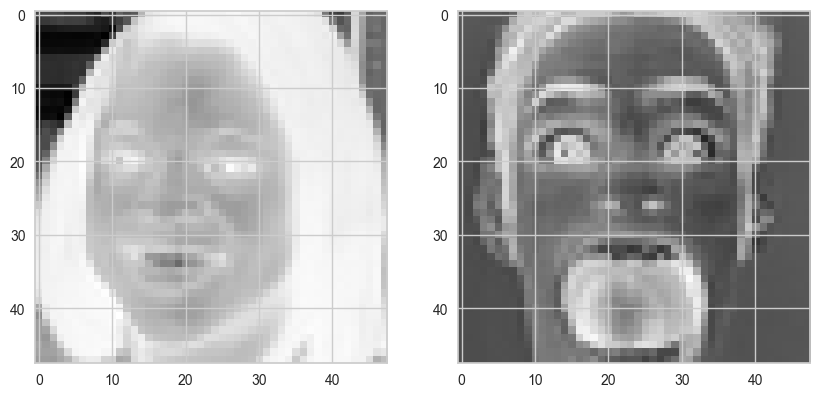

In [ ]:
ds = ICMLDataset(data)
plot_image([ds[0]["image"], ds[1]["image"]])

In [ ]:
class ICML(L.LightningDataModule):
    def __init__(self, dataset, batch_size, num_workers):
        super(ICML, self).__init__()

        self.dataset = dataset

        self.loader_params = {
            'batch_size': batch_size,
            'num_workers': num_workers,
            'persistent_workers': True
        }

        self.train_transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.uint8, scale=True),
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.test_transform = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.uint8, scale=True),
            v2.Resize(size=(224, 224), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.val = None
        self.train = None
        self.test = None
        self.pred = None

    def prepare_data(self) -> None:
        self.train, self.test = train_test_split(self.dataset, test_size=0.2, random_state=42)
        self.train, self.val = train_test_split(self.train, test_size=0.2, random_state=42)
        self.test, self.pred = train_test_split(self.test, test_size=0.5, random_state=42)

    def setup(self, stage: str) -> None:
        if stage == "fit":
            self.train = ICMLDataset(
                self.train,
                # transform=self.train_transform
            )

            self.val = ICMLDataset(
                self.val,
                # transform=self.test_transform
            )

        if stage == "test":
            self.test = ICMLDataset(
                self.test,
                # transform=self.test_transform
            )

        if stage == "predict":
            self.pred = ICMLDataset(
                self.pred,
                # transform=self.test_transform
            )

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.train, **self.loader_params, shuffle=True)

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.val, **self.loader_params)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.test, **self.loader_params)

    def predict_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.pred, **self.loader_params)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


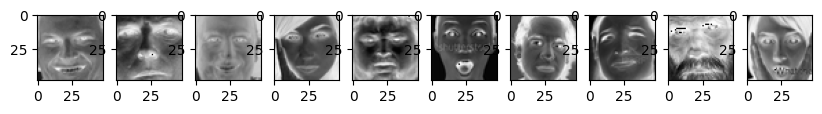

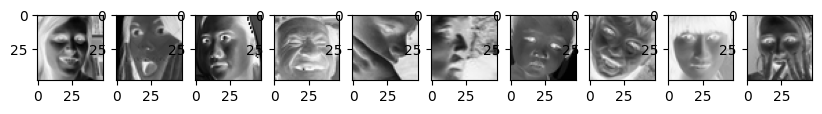

In [ ]:
icml = ICML(data, 10, 2)
icml.prepare_data()
icml.setup("fit")
train_loader = icml.train_dataloader()

first_batch = next(iter(train_loader))
plot_image(next(iter(train_loader))["image"])

icml.setup("test")
test_loader = icml.test_dataloader()
plot_image(next(iter(test_loader))["image"])

In [ ]:
class VGGModule(L.LightningModule):
    def __init__(self, num_classes=7, lr=1e-4):
        super(VGGModule, self).__init__()

        self.model = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
        for param in self.model.parameters():
            param.requires_grad = False

        n_inputs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x = batch["image"]
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc",
                               mode="max",
                               min_delta=1e-4,
                               patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = VGGModule()
data_module = ICML(data, 8, 2)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)
trainer.test(model, data_module)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 2871: 'val_acc' reached 0.24747 (best 0.24747), saving model to '/content/checkpoint/epoch=0-step=2871.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 2871: 'val_acc' reached 0.24747 (best 0.24747), saving model to '/content/checkpoint/epoch=0-step=2871.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 5742: 'val_acc' reached 0.25514 (best 0.25514), saving model to '/content/checkpoint/epoch=1-step=5742-v1.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 5742: 'val_acc' reached 0.25514 (best 0.25514), saving model to '/content/checkpoint/epoch=1-step=5742-v1.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.24937307834625244    │
│         test_loss         │     1.780709981918335     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.780709981918335, 'test_acc': 0.24937307834625244}]

In [ ]:
class ResnetModule(L.LightningModule):
    def __init__(self, num_classes=7, lr=1e-4):
        super(ResnetModule, self).__init__()

        self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
        for param in self.model.parameters():
            param.requires_grad = False

        n_inputs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x = batch["image"]
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc",
                               mode="max",
                               min_delta=1e-4,
                               patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResnetModule()
data_module = ICML(data, 8, 2)
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)
trainer.fit(model, data_module)
trainer.test(model, data_module)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utiliti

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
INFO: Epoch 0, global step 2871: 'val_acc' reached 0.31505 (best 0.31505), saving model to '/content/checkpoint/epoch=0-step=2871.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 2871: 'val_acc' reached 0.31505 (best 0.31505), saving model to '/content/checkpoint/epoch=0-step=2871.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 5742: 'val_acc' reached 0.33037 (best 0.33037), saving model to '/content/checkpoint/epoch=1-step=5742-v2.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 5742: 'val_acc' reached 0.33037 (best 0.33037), saving model to '/content/checkpoint/epoch=1-step=5742-v2.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3340763449668884     │
│         test_loss         │    1.7953487634658813     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.7953487634658813, 'test_acc': 0.3340763449668884}]

### 3.2. Using PCA to train 

In [14]:
# using pca with 104 components
pca_ = PCA(n_components=104)
pca_.fit(x_train)

PCA(n_components=104)

In [15]:
x_train_pca = pca_.transform(x_train)
x_test_pca = pca_.transform(x_test)

* Create PCA Pipelines

In [16]:
# reuse create_pipelines function to train with pca data
pca_pipelines = create_pipelines()

* Getting metrics from PCA Pipelines

In [17]:
# define metrics from pca pipelines
def metrics_from_pca_pipelines(x_train_: pd.DataFrame,
                               y_train_: pd.Series,
                               x_test_: pd.DataFrame,
                               y_test_: pd.Series) -> style.Styler:
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_aps = []
    train_precs = []
    train_recs = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_aps = []
    test_precs = []
    test_recs = []

    for _, pipeline in pca_pipelines.items():
        pipeline.fit(x_train_, y_train_)
        y_pred_test = pipeline.predict(x_test_)
        y_pred_train = pipeline.predict(x_train_)

        y_probs_test = pipeline.predict_proba(x_test_)
        y_probs_train = pipeline.predict_proba(x_train_)

        train_roc_aucs.append(roc_auc_score(
            y_train_, y_probs_train, multi_class='ovr'))
        test_roc_aucs.append(roc_auc_score(
            y_test_, y_probs_test, multi_class='ovr'))

        train_aps.append(average_precision_score(y_train_, y_probs_train, average='weighted'))
        test_aps.append(average_precision_score(y_test_, y_probs_test, average='weighted'))

        train_accs.append(accuracy_score(y_train_, y_pred_train))
        test_accs.append(accuracy_score(y_test_, y_pred_test))

        train_f1s.append(f1_score(y_train_, y_pred_train, average='weighted'))
        test_f1s.append(f1_score(y_test_, y_pred_test, average='weighted'))

        train_precs.append(precision_score(
            y_train_, y_pred_train, average='weighted'))
        test_precs.append(precision_score(
            y_test_, y_pred_test, average='weighted'))

        train_recs.append(recall_score(
            y_train_, y_pred_train, average='weighted'))
        test_recs.append(recall_score(y_test_, y_pred_test, average='weighted'))

    # Aggregate the performance metric lists into separate dataframes
    train_metrics = pd.DataFrame({
        'model': pca_pipelines.keys(),
        'accuracy': train_accs,
        'f1_score': train_f1s,
        'roc_auc': train_roc_aucs,
        'ap': train_aps,
        'precision': train_precs,
        'recall': train_recs
    })

    test_metrics = pd.DataFrame({
        'model': pca_pipelines.keys(),
        'accuracy': test_accs,
        'f1_score': test_f1s,
        'roc_auc': test_roc_aucs,
        'ap': test_aps,
        'precision': test_precs,
        'recall': test_recs
    })

    # Merging metrics from train and test set
    train_test_metrics = train_metrics.merge(test_metrics,
                                             on='model',
                                             how='left',
                                             suffixes=('_train', '_test'))
    
    # Sorting coulmns
    train_test_metrics = train_test_metrics.reindex(columns=['model',
                                                             'accuracy_train',
                                                             'accuracy_test',
                                                             'f1_score_train',
                                                             'f1_score_test',
                                                             'roc_auc_train',
                                                             'roc_auc_test',
                                                             'ap_train',
                                                             'ap_test',
                                                             'precision_train',
                                                             'precision_test',
                                                             'recall_train',
                                                             'recall_test'])
    
    return train_test_metrics.set_index('model').transpose().style \
        .background_gradient(cmap='BuGn') \
        .set_properties(**{'font-size': '10pt',
                           'width': '200px',
                           'height': '30px',
                           'text-align': 'center'}) \
        .set_table_styles([{'selector': 'th',
                            'props': [
                                ('text-align', 'center'),
                                ('font-size', '10pt')]}])\
        .set_caption('Table 4. Model performance metrics with PCA')\
        .set_table_attributes('style="font-size: 16px; margin: 0 auto;"')

metrics_from_pca_pipelines(x_train_pca, y_train, x_test_pca, y_test)

model,K Nearest Neighbors,Logistic Regression,Random Forest
accuracy_train,0.564980,0.381727,0.998433
accuracy_test,0.365979,0.369462,0.434940
f1_score_train,0.559591,0.345904,0.998433
f1_score_test,0.359345,0.333866,0.413002
roc_auc_train,0.907697,0.714609,0.999963
roc_auc_test,0.699282,0.704571,0.752891
ap_train,0.579936,0.354456,0.999764
ap_test,0.319717,0.338370,0.472332
precision_train,0.586221,0.356195,0.998434
precision_test,0.374426,0.348087,0.483775


* Cross Validation PCA pipelines

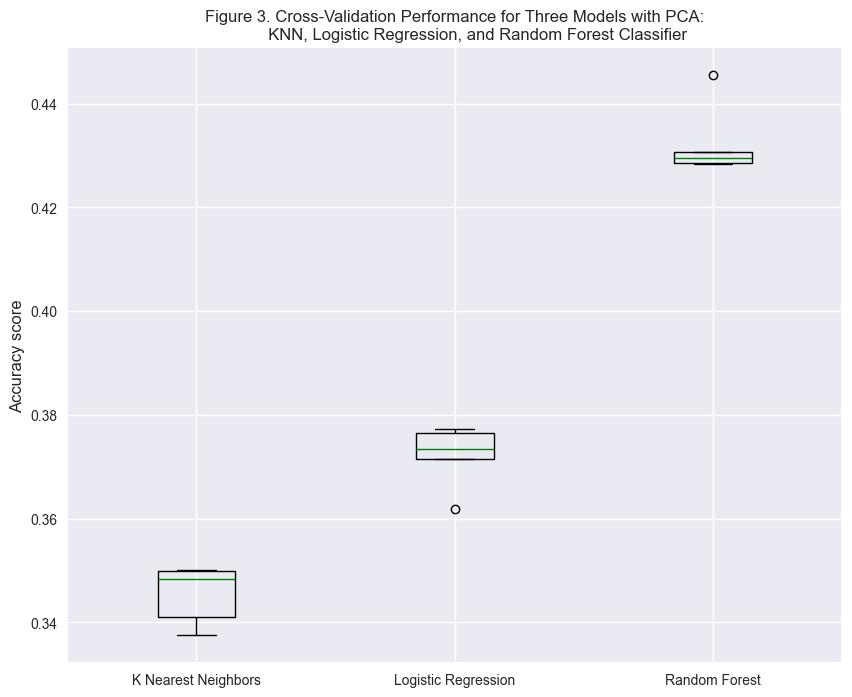

,Test Set Accuracy
K Nearest Neighbors,0.365422
Logistic Regression,0.369044
Random Forest,0.433129


In [27]:
# boxplot cv performances from pca pipelines
def boxplot_cv_performances_from_pca_pipes(x_train_: pd.DataFrame,
                                           y_train_: pd.Series,
                                           x_test_: pd.DataFrame,
                                           y_test_: pd.Series) -> pd.DataFrame:
    results = []

    for pipeline in pca_pipelines.values():
        kf = KFold(n_splits=5)
        cv_results = cross_val_score(pipeline, x_train_, y_train_, cv=kf)
        results.append(cv_results)

    # Plot Cross-Validation Performance
    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 8))
    plt.boxplot(results, labels=list(pca_pipelines.keys()),
                medianprops={'color': 'green'})
    plt.ylabel('Accuracy score', fontsize=12)

    plt.title('Figure 3. Cross-Validation Performance for Three Models with PCA:\n\
          KNN, Logistic Regression, and Random Forest Classifier')
    plt.show()

    # Test set performance
    test_set_performance = pd.DataFrame(index=list(pca_pipelines.keys()),
                                        columns=['Test Set Accuracy'])
    for name, pipeline in pca_pipelines.items():
        pipeline.fit(x_train_, y_train_)
        y_pred = pipeline.predict(x_test_)
        test_set_performance.loc[name, 'Test Set Accuracy'] = accuracy_score(y_test_, y_pred)

    return test_set_performance

boxplot_cv_performances_from_pca_pipes(x_train_pca, y_train, x_test_pca, y_test)

* ROC AUC plot

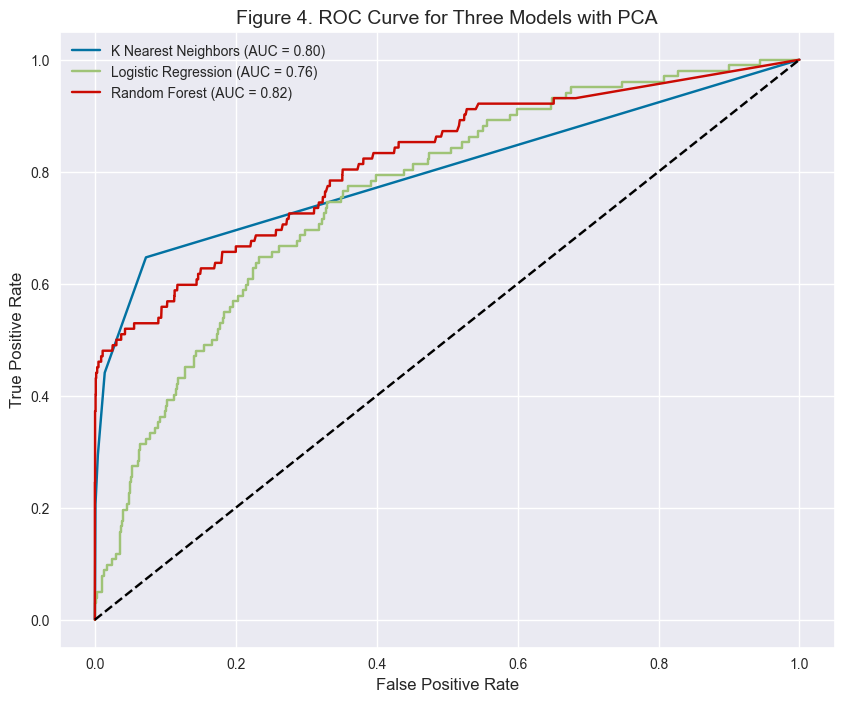

In [28]:
# ROC AUC curve for pca pipelines for each label
def plot_roc_curve_pca(x_train_: pd.DataFrame,
                       y_train_: pd.Series,
                       x_test_: pd.DataFrame,
                       y_test_: pd.Series) -> None:
    plt.figure(figsize=(10, 8))
    [plt.plot(*roc_curve(y_test_, pipeline.predict_proba(x_test_)[:, 1], pos_label=1)[:2], 
              label=f'{name} (AUC = {auc(*roc_curve(y_test_, pipeline.predict_proba(x_test_)[:, 1], pos_label=1)[:2]):.2f})') 
     for name, pipeline in pca_pipelines.items()]
    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Figure 4. ROC Curve for Three Models with PCA', fontsize=14)
    plt.legend()
    plt.show()

plot_roc_curve_pca(x_train_pca, y_train, x_test_pca, y_test)

* Hyperparameter tuning

In [32]:
# tuning knn, logistic regression and random forest with pca
def hyperparameter_tuning_pca(x_train_: pd.DataFrame,
                              y_train_: pd.Series) -> Dict[str, OneVsRestClassifier]:
    tuned_pipelines = {
        'K Nearest Neighbors': OneVsRestClassifier(make_pipeline(KNeighborsClassifier(n_jobs=-1))),
        'Logistic Regression': OneVsRestClassifier(make_pipeline(LogisticRegression(n_jobs=-1))),
        'Random Forest': OneVsRestClassifier(make_pipeline(RandomForestClassifier(n_jobs=-1)))
    }

    for name, pipeline in tuned_pipelines.items():
        if name == 'K Nearest Neighbors':
            # Define the number of neighbors to test
            param_grid = {
                'estimator__kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
                'estimator__kneighborsclassifier__weights': ['uniform', 'distance']
            }
        elif name == 'Logistic Regression':
            # Define the regularization parameter space
            param_grid = {
                'estimator__logisticregression__C': [0.01, 0.1, 1, 10, 100],
                'estimator__logisticregression__penalty': ['l1', 'l2']
            }
        elif name == 'Random Forest':
            # Define the number of trees to test
            param_grid = {
                'estimator__randomforestclassifier__n_estimators': [50, 100, 150],
                'estimator__randomforestclassifier__max_depth': [3, 5, 7]
            }
        # Perform grid search with 5-fold cross-validation
        kf = KFold(n_splits=5)
        grid_search = GridSearchCV(pipeline, param_grid, cv=kf)
        grid_search.fit(x_train_, y_train_)

        print(f"Best parameters for {name}: {grid_search.best_params_}")

    return tuned_pipelines

tuned_KNN_LR_RF_pipelines = hyperparameter_tuning_pca(x_train_pca, y_train)

Best parameters for K Nearest Neighbors: {'estimator__kneighborsclassifier__n_neighbors': 11, 'estimator__kneighborsclassifier__weights': 'distance'}
Best parameters for Logistic Regression: {'estimator__logisticregression__C': 0.01, 'estimator__logisticregression__penalty': 'l2'}
Best parameters for Random Forest: {'estimator__randomforestclassifier__max_depth': 7, 'estimator__randomforestclassifier__n_estimators': 150}


## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



From the above results:

|Model|Accuracy|Precision|Recall|F1|
|-----|:------:|:-------:|:----:|:-:|
|KNN|0.34|0.36|0.34|0.33|
|Logistic Regression|0.35|0.33|0.35|0.34|
|Random Forest|0.47|0.49|0.47|0.45|

We can saw that `Random Forest` model performs the best among the 3 classification models based on all the provided evaluation metrics: accuracy, precision, recall, and F1-score.

In [48]:
# labels_name 
labels_name = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [51]:
# confusion matrix 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral by heatmap
def plot_confusion_matrix(y_true, y_pred, labels, model_name):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(15, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### 4.1. Original Data

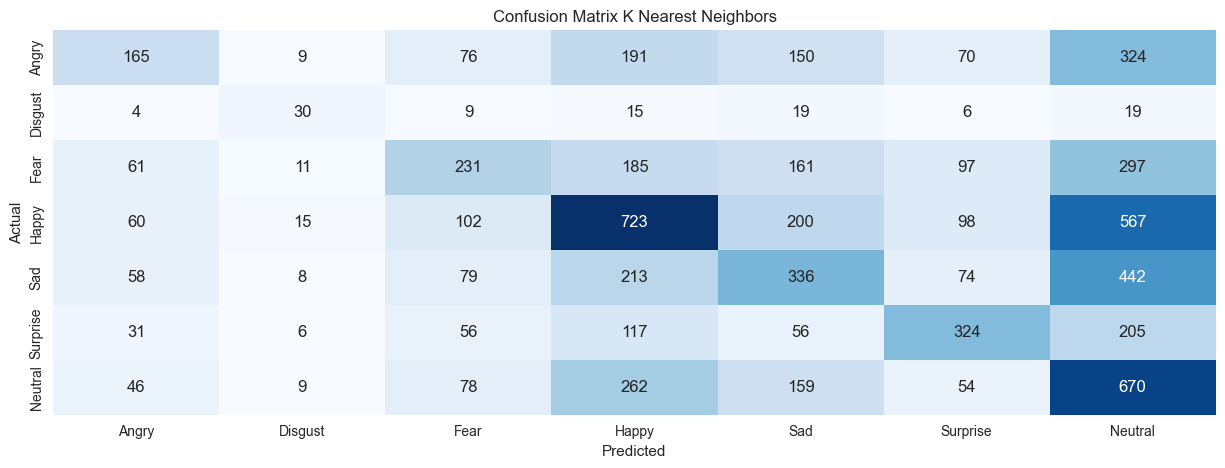

In [52]:
## visualize the confusion matrices and classification reports here
plot_confusion_matrix(y_test, loaded_model['K Nearest Neighbors'].predict(x_test), labels_name, 'K Nearest Neighbors')

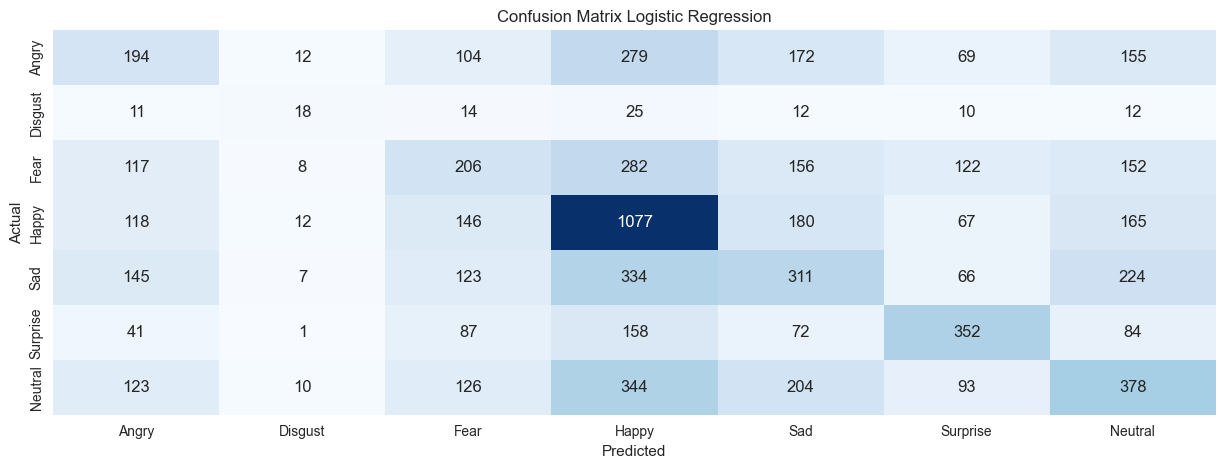

In [53]:
plot_confusion_matrix(y_test, loaded_model['Logistic Regression'].predict(x_test), labels_name, 'Logistic Regression')

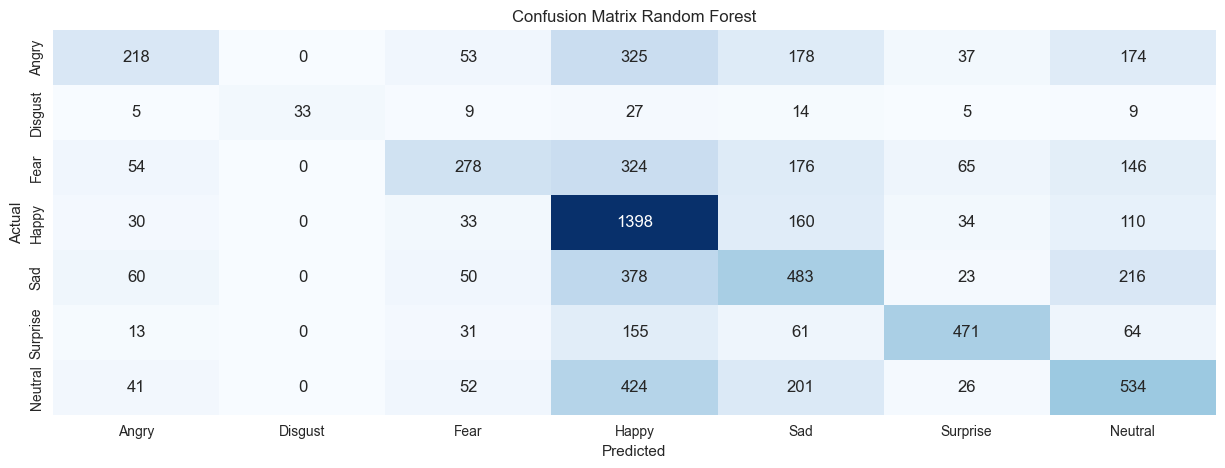

In [54]:
plot_confusion_matrix(y_test, loaded_model['Random Forest'].predict(x_test), labels_name, 'Random Forest')

### 4.2. PCA data

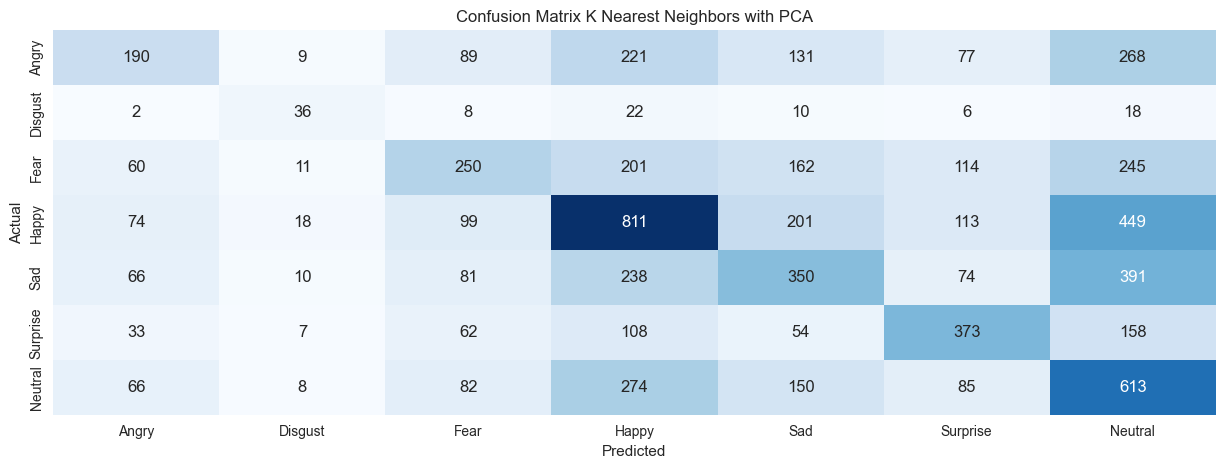

In [55]:
# Confusion matrix pca
plot_confusion_matrix(y_test, pca_pipelines['K Nearest Neighbors'].predict(x_test_pca), labels_name, 'K Nearest Neighbors with PCA')

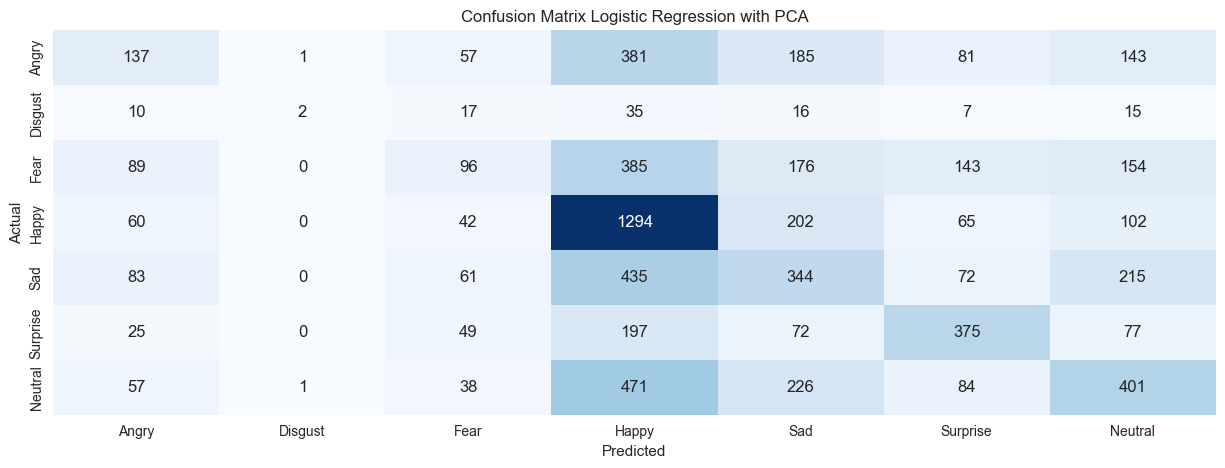

In [56]:
plot_confusion_matrix(y_test, pca_pipelines['Logistic Regression'].predict(x_test_pca), labels_name, 'Logistic Regression with PCA')

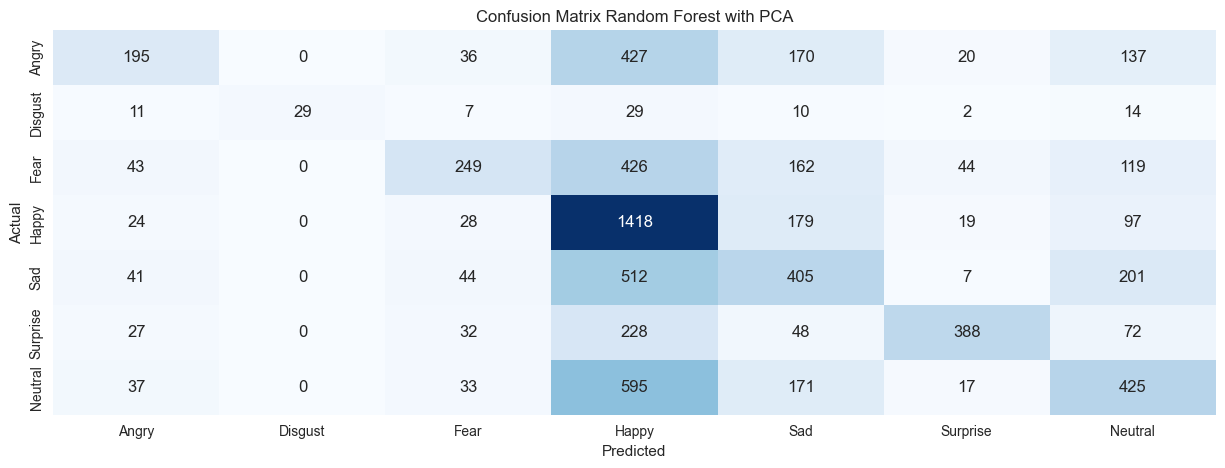

In [57]:
plot_confusion_matrix(y_test, pca_pipelines['Random Forest'].predict(x_test_pca), labels_name, 'Random Forest with PCA')

=> The emotion category where models are most accurate is 3 (Happy), and the category with the most errors is 1 (Disgust). This makes sense because of the imbalance in the dataset: the least common label is 1 and the most common is 3